# Analyzing the Data

In [239]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)

from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

import json

In [240]:
base_directory = os.path.join('..', 'E:\skincode\skin-cancer-mnist-ham10000')

In [241]:
imageid_paths = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_directory, '*', '*.jpg'))}

In [242]:
dataset = pd.read_csv(os.path.join(base_directory, 'HAM10000_metadata.csv'))

In [243]:
print(dataset.shape)

(10015, 7)


In [244]:
print(dataset.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [245]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


In [246]:
print(dataset['dx'].unique())

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [247]:
cell_types = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

dataset['cell_types'] = dataset['dx'].replace({'bkl': 'Benign keratosis-like lesions', 'nv': 'Melanocytic nevi',
                                               'df': 'Dermatofibroma', 'mel': 'dermatofibroma', 'vasc': 'Vascular lesions', 
                                               'bcc': 'Basal cell carcinoma', 'akiec': 'Actinic keratoses'})

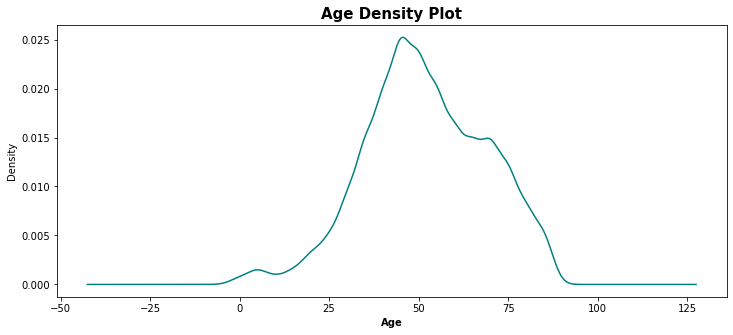

In [248]:
plt.figure(figsize = (12, 5))
dataset['age'].plot(kind='density', color='teal')
plt.title("Age Density Plot", fontsize=15, fontweight='bold')
plt.xlabel("Age", fontweight='bold')
plt.show()

In [249]:
dataset['age'].fillna((dataset['age'].mean()), inplace=True)

In [250]:
print(dataset.isnull().sum())

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64


In [251]:
dataset['image_path'] = dataset['image_id'].map(imageid_paths.get)
dataset['cell_type'] = dataset['dx'].map(cell_types.get) 
dataset['cell_type_idx'] = pd.Categorical(dataset['cell_type']).codes

In [252]:
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Exploratory Data Analysis

In [253]:
import seaborn as sns

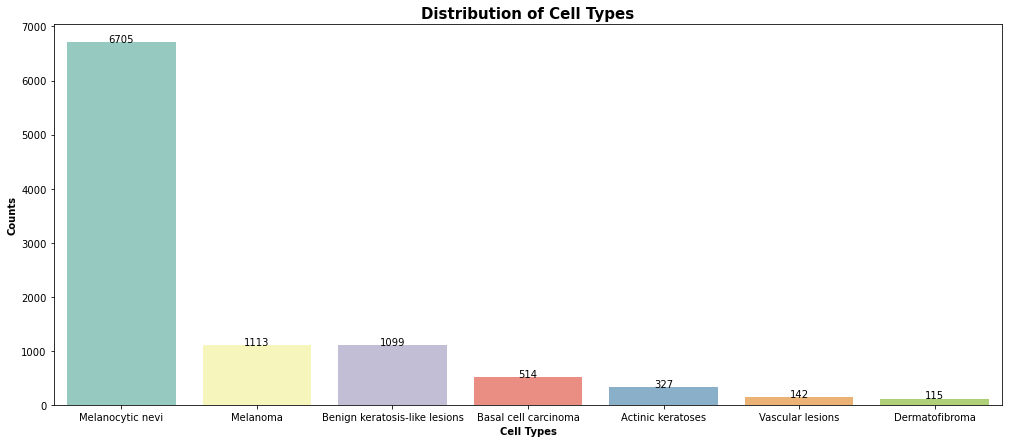

In [254]:
labels=dataset['cell_type'].value_counts().index
values=dataset['cell_type'].value_counts().values

plt.figure(figsize = (17, 7))
ax = sns.barplot(x=labels, y=values, palette="Set3")
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, values[i],ha="center")
plt.title("Distribution of Cell Types", fontsize=15, fontweight='bold')
plt.ylabel("Counts", fontweight='bold')
plt.xlabel("Cell Types", fontweight='bold')
plt.show()

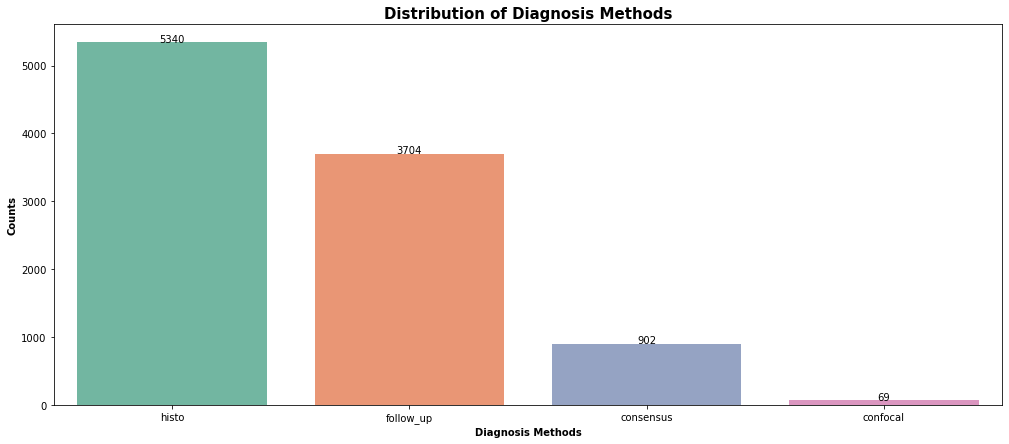

In [255]:
labels=dataset['dx_type'].value_counts().index
values=dataset['dx_type'].value_counts().values

plt.figure(figsize = (17, 7))
ax = sns.barplot(x=labels, y=values, palette="Set2")
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, values[i],ha="center")
plt.title("Distribution of Diagnosis Methods", fontsize=15, fontweight='bold')
plt.ylabel("Counts", fontweight='bold')
plt.xlabel("Diagnosis Methods", fontweight='bold')
plt.show()

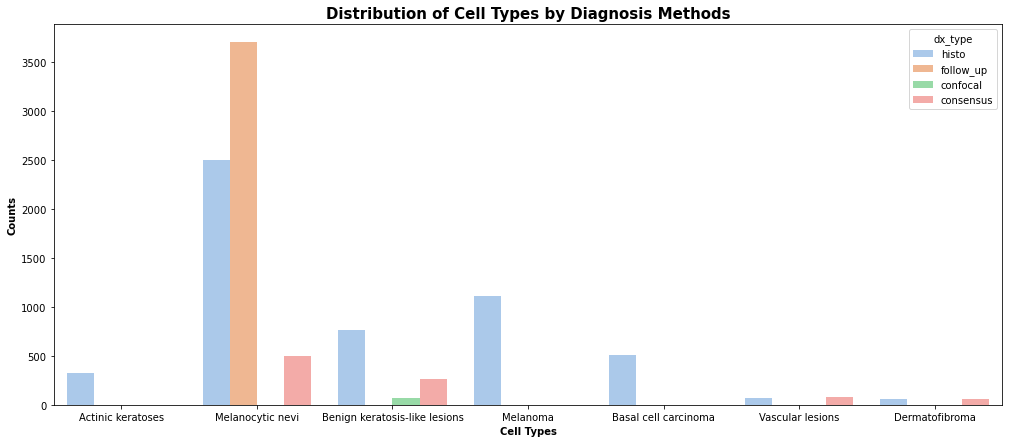

In [256]:
plt.figure(figsize = (17, 7))
sns.countplot(data=dataset, x="cell_type", hue="dx_type", palette="pastel")
plt.title("Distribution of Cell Types by Diagnosis Methods", fontsize=15, fontweight='bold')
plt.ylabel("Counts", fontweight='bold')
plt.xlabel("Cell Types", fontweight='bold')
plt.show()

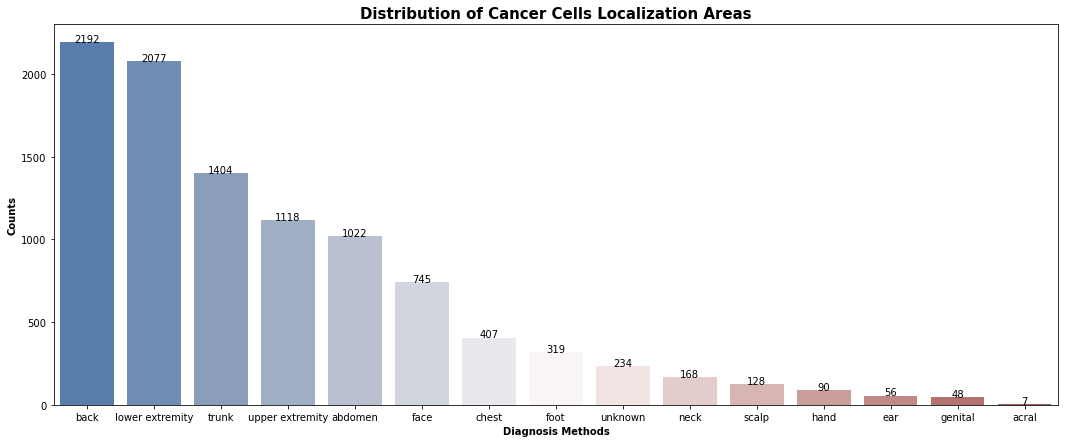

In [257]:
labels=dataset['localization'].value_counts().index
values=dataset['localization'].value_counts().values

plt.figure(figsize = (18, 7))
ax = sns.barplot(x=labels, y=values, palette="vlag")
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, values[i],ha="center")
plt.title("Distribution of Cancer Cells Localization Areas", fontsize=15, fontweight='bold')
plt.ylabel("Counts", fontweight='bold')
plt.xlabel("Diagnosis Methods", fontweight='bold')
plt.show()

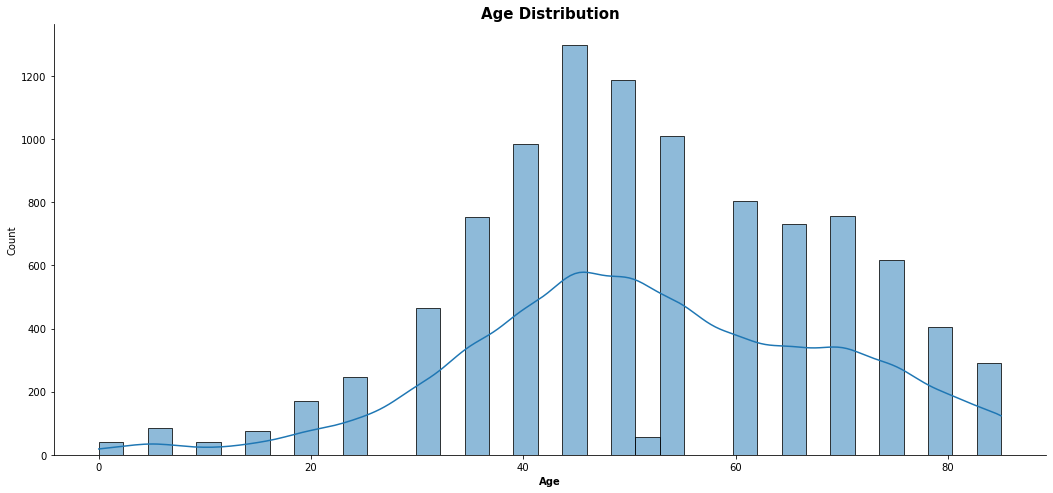

In [258]:
ax=sns.displot(data=dataset, x="age", kde=True)
ax.fig.set_size_inches(17,7)
plt.title("Age Distribution", fontsize=15, fontweight='bold')
plt.xlabel("Age", fontweight='bold')
plt.show()

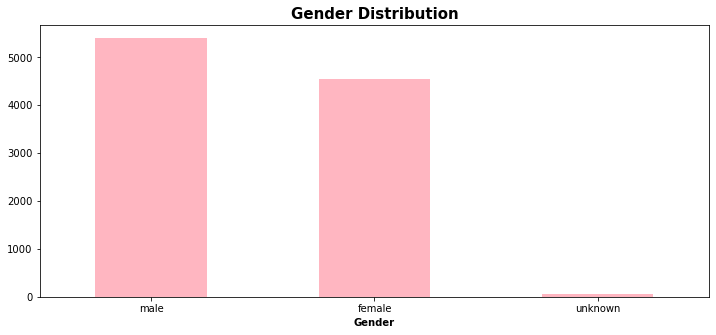

In [259]:
plt.figure(figsize = (12, 5))
dataset['sex'].value_counts().plot(kind='bar', color='lightpink')
plt.title("Gender Distribution", fontsize=15, fontweight='bold')
plt.xticks(rotation=0)
plt.xlabel("Gender", fontweight='bold')
plt.show()

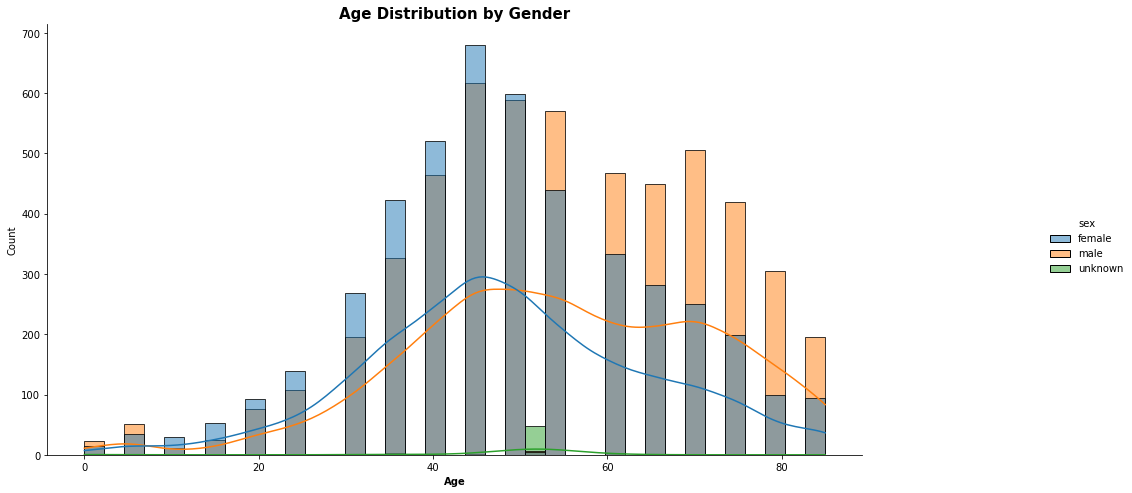

In [260]:
ax=sns.displot(data=dataset, x="age", hue="sex", kde=True)
ax.fig.set_size_inches(17,7)
plt.title("Age Distribution by Gender", fontsize=15, fontweight='bold')
plt.xlabel("Age", fontweight='bold')
plt.show()

In [261]:
dataset['image'] = dataset['image_path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [262]:
sorted_df = dataset.sort_values(['cell_type']).groupby('cell_type').groups

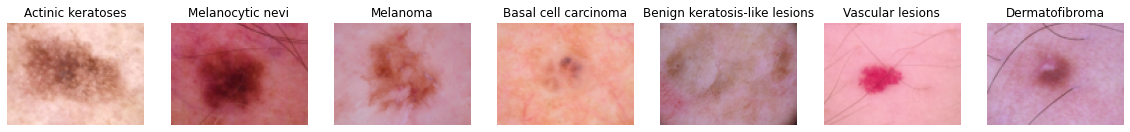

In [263]:
cells = ["Actinic keratoses", "Melanocytic nevi", "Melanoma", "Basal cell carcinoma", "Benign keratosis-like lesions", 
         "Vascular lesions", "Dermatofibroma"]

plt.figure(figsize=(20,6))
for index, item in enumerate(cells, 1):
    plt.subplot(1,7,index)
    plt.imshow(dataset['image'][sorted_df[item][0]])
    plt.title(dataset['cell_type'][sorted_df[item][0]])
    plt.axis('off')
plt.show()

In [264]:
print(dataset['image'].map(lambda x: x.shape).value_counts())

(75, 100, 3)    10015
Name: image, dtype: int64


# Building the Model

In [265]:
indexes = dataset[dataset.cell_type=="Melanocytic nevi"].index

In [266]:
indexes = indexes.to_numpy()

In [267]:
indexes_dropped = np.random.choice(indexes, size=5700, replace=False)

In [268]:
dataset.drop(dataset.index[indexes_dropped], inplace=True)

In [269]:
dataset[dataset.cell_type=="Melanocytic nevi"].index

Int64Index([   4,    8,   16,   43,   50,   69,   73,   77,   82,   85,
            ...
            9883, 9903, 9948, 9955, 9965, 9966, 9968, 9976, 9980, 9993],
           dtype='int64', length=1005)

In [270]:
x=dataset.drop(columns=['cell_type_idx'],axis=1)
y=dataset['cell_type_idx']

In [362]:
x_test_o

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,cell_type,image
906,HAM_0002024,ISIC_0029412,bcc,histo,80.0,male,back,E:\skincode\skin-cancer-mnist-ham10000\HAM1000...,Basal cell carcinoma,"[[[212, 191, 204], [208, 184, 194], [209, 184,..."
7035,HAM_0001759,ISIC_0032497,bcc,histo,70.0,female,lower extremity,E:\skincode\skin-cancer-mnist-ham10000\HAM1000...,Basal cell carcinoma,"[[[175, 139, 137], [183, 148, 143], [193, 160,..."
7648,HAM_0000645,ISIC_0029513,mel,histo,70.0,male,trunk,E:\skincode\skin-cancer-mnist-ham10000\HAM1000...,Melanoma,"[[[31, 16, 24], [47, 28, 38], [65, 44, 52], [8..."
3427,HAM_0000910,ISIC_0028017,mel,histo,50.0,female,back,E:\skincode\skin-cancer-mnist-ham10000\HAM1000...,Melanoma,"[[[187, 161, 165], [187, 161, 167], [188, 160,..."
5126,HAM_0000445,ISIC_0032010,nv,follow_up,50.0,female,trunk,E:\skincode\skin-cancer-mnist-ham10000\HAM1000...,Melanocytic nevi,"[[[249, 188, 197], [249, 189, 196], [249, 191,..."
...,...,...,...,...,...,...,...,...,...,...
7019,HAM_0003832,ISIC_0025450,mel,histo,60.0,female,lower extremity,E:\skincode\skin-cancer-mnist-ham10000\HAM1000...,Melanoma,"[[[194, 167, 215], [193, 167, 214], [196, 173,..."
9592,HAM_0005883,ISIC_0026018,bkl,histo,65.0,male,back,E:\skincode\skin-cancer-mnist-ham10000\HAM1000...,Benign keratosis-like lesions,"[[[124, 102, 114], [127, 106, 119], [129, 109,..."
4567,HAM_0005893,ISIC_0032833,mel,histo,55.0,male,trunk,E:\skincode\skin-cancer-mnist-ham10000\HAM1000...,Melanoma,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
670,HAM_0004396,ISIC_0029443,bkl,histo,65.0,male,upper extremity,E:\skincode\skin-cancer-mnist-ham10000\HAM1000...,Benign keratosis-like lesions,"[[[193, 158, 176], [192, 155, 175], [193, 160,..."


In [271]:
from sklearn.model_selection import train_test_split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(x, y, test_size=0.20, random_state=1234)

In [272]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [273]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [274]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))

In [292]:
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.30))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.30))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 25, 64)       

In [293]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [294]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [295]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [296]:
datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                zoom_range = 0.1, # Randomly zoom image 
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=False,  # randomly flip images
                vertical_flip=False)  # r) 

datagen.fit(x_train)

In [299]:
epochs = 50
batch_size = 16
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = epochs, 
                    validation_data = (x_test,y_test),
                    verbose = 1,callbacks=[learning_rate_reduction])

Epoch 1/50
216/216 [==============================] - 674s 3s/step - loss: 1.2354 - accuracy: 0.5200 - val_loss: 1.1174 - val_accuracy: 0.5678
Epoch 2/50
216/216 [==============================] - 677s 3s/step - loss: 1.1782 - accuracy: 0.5539 - val_loss: 1.1292 - val_accuracy: 0.5539
Epoch 3/50
216/216 [==============================] - 670s 3s/step - loss: 1.1466 - accuracy: 0.5548 - val_loss: 1.1291 - val_accuracy: 0.5643
Epoch 4/50
216/216 [==============================] - ETA: 0s - loss: 1.1111 - accuracy: 0.5716
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
216/216 [==============================] - 683s 3s/step - loss: 1.1111 - accuracy: 0.5716 - val_loss: 1.0698 - val_accuracy: 0.5608
Epoch 5/50
216/216 [==============================] - 610s 3s/step - loss: 1.0375 - accuracy: 0.5936 - val_loss: 1.0245 - val_accuracy: 0.6141
Epoch 6/50
216/216 [==============================] - 285s 1s/step - loss: 1.0071 - accuracy: 0.6127 - val_loss: 1.0569 

In [300]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

27/27 [==============================] - 26s 978ms/step - loss: 0.9732 - accuracy: 0.6628
Test: accuracy = 0.662804  ;  loss = 0.973190


In [370]:
model.save("mymodel.h5")

In [371]:
model.load_weights('mymodel.h5')

In [366]:
predictions = model.predict(x_test, steps=32, verbose=1)

32/32 [==============================] - 30s 949ms/step


In [372]:
load_model('mymodel.h5')

In [373]:
labelInfo = dataset.cell_type
labelInfo=labelInfo.to_json()

In [374]:
with open("sample.json", "w") as outfile: 
    outfile.write(json.dumps(labelInfo))

In [375]:
with open('sample.json', 'r') as f:
    labelInfo = json.load(f)

In [376]:
labelInfo = json.loads(labelInfo)

In [378]:
dataset.reset_index(drop=True, inplace=True)

In [383]:
labelInfo

{'0': 'Actinic keratoses',
 '1': 'Melanocytic nevi',
 '2': 'Benign keratosis-like lesions',
 '3': 'Melanocytic nevi',
 '4': 'Melanoma',
 '5': 'Melanocytic nevi',
 '6': 'Melanoma',
 '7': 'Benign keratosis-like lesions',
 '8': 'Benign keratosis-like lesions',
 '9': 'Benign keratosis-like lesions',
 '10': 'Benign keratosis-like lesions',
 '11': 'Basal cell carcinoma',
 '12': 'Melanoma',
 '13': 'Vascular lesions',
 '14': 'Melanoma',
 '15': 'Benign keratosis-like lesions',
 '16': 'Melanoma',
 '17': 'Melanocytic nevi',
 '18': 'Benign keratosis-like lesions',
 '19': 'Actinic keratoses',
 '20': 'Melanoma',
 '21': 'Melanocytic nevi',
 '22': 'Benign keratosis-like lesions',
 '23': 'Benign keratosis-like lesions',
 '24': 'Benign keratosis-like lesions',
 '25': 'Benign keratosis-like lesions',
 '26': 'Basal cell carcinoma',
 '27': 'Melanocytic nevi',
 '28': 'Melanoma',
 '29': 'Melanocytic nevi',
 '30': 'Melanocytic nevi',
 '31': 'Actinic keratoses',
 '32': 'Melanocytic nevi',
 '33': 'Melanocytic n

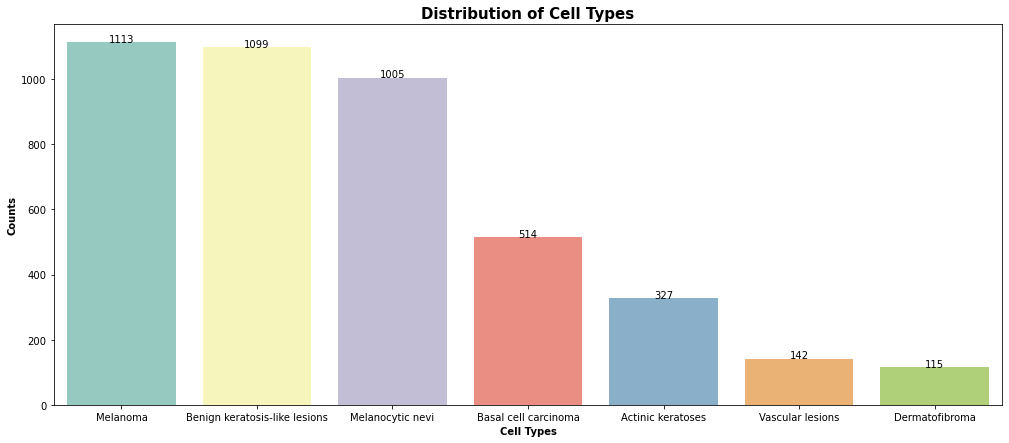

In [363]:
labels=dataset['cell_type'].value_counts().index
values=dataset['cell_type'].value_counts().values

plt.figure(figsize = (17, 7))
ax = sns.barplot(x=labels, y=values, palette="Set3")
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, values[i],ha="center")
plt.title("Distribution of Cell Types", fontsize=15, fontweight='bold')
plt.ylabel("Counts", fontweight='bold')
plt.xlabel("Cell Types", fontweight='bold')
plt.show()